In [1]:
import cv2
import mediapipe as mp
import pandas as pd
import os

# Initialize MediaPipe Pose
mp_pose = mp.solutions.pose
pose = mp_pose.Pose(static_image_mode=False, min_detection_confidence=0.5, min_tracking_confidence=0.5)

# Video path (update your filename if needed)
video_path = '123.mp4'

# Open video
cap = cv2.VideoCapture(video_path)

# Check video is opened
if not cap.isOpened():
    print("❌ Failed to open video")
else:
    print("✅ Video opened successfully")

# CSV data list
landmark_data = []

frame_count = 0

# Loop through video frames
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    frame_count += 1

    # Convert the frame color (OpenCV uses BGR, MediaPipe uses RGB)
    image_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    # Process the frame with MediaPipe Pose
    results = pose.process(image_rgb)

    # If landmarks detected
    if results.pose_landmarks:
        landmarks = results.pose_landmarks.landmark

        # Extract x, y, z, visibility for each landmark
        frame_landmarks = []
        for lm in landmarks:
            frame_landmarks.extend([lm.x, lm.y, lm.z, lm.visibility])

        # Add frame number at the start
        row = [frame_count] + frame_landmarks
        landmark_data.append(row)

cap.release()
pose.close()

# Column names for CSV
landmark_names = []
for i in range(33):
    landmark_names.extend([f'L{i}_x', f'L{i}_y', f'L{i}_z', f'L{i}_visibility'])

columns = ['frame'] + landmark_names

# Save to CSV
df = pd.DataFrame(landmark_data, columns=columns)
csv_path = 'pose_landmarks.csv'
df.to_csv(csv_path, index=False)

print(f"✅ Landmarks saved to {csv_path}")

✅ Video opened successfully
✅ Landmarks saved to pose_landmarks.csv


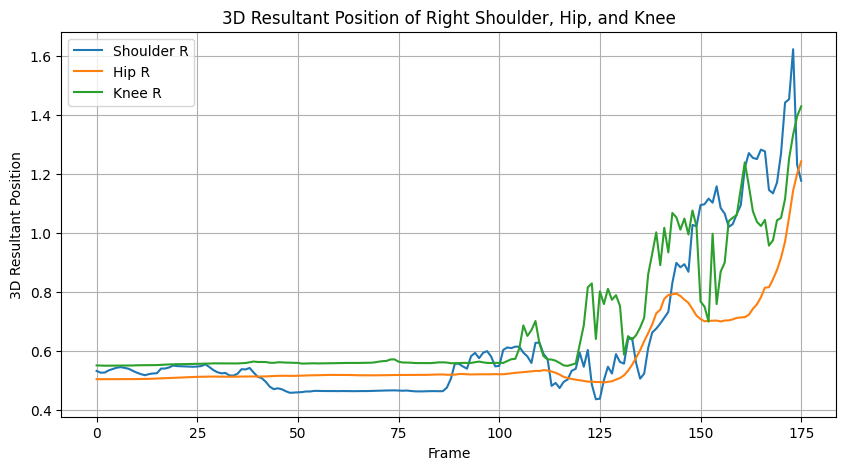

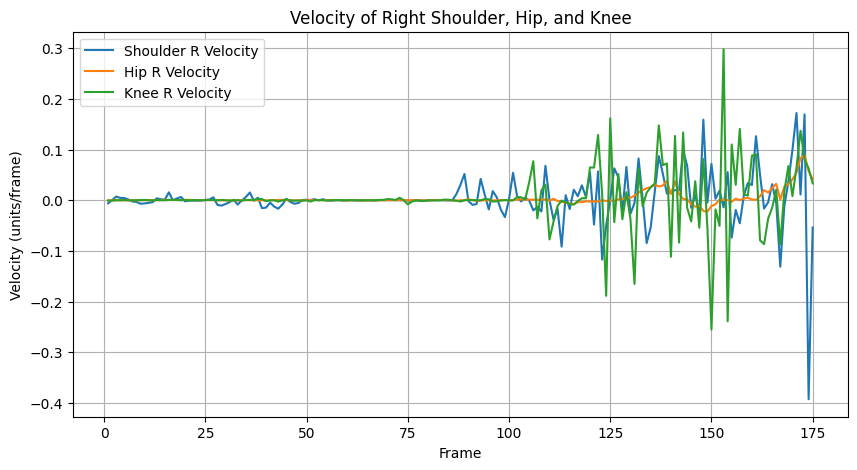

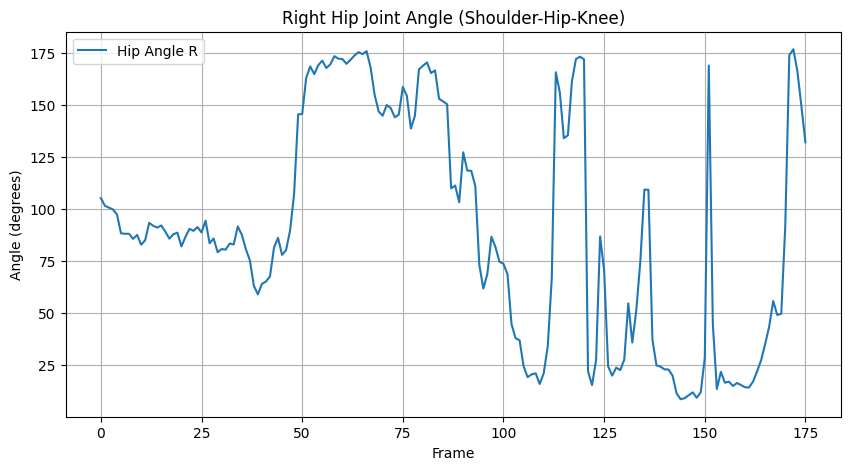

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Load landmark CSV
landmarks_df = pd.read_csv("pose_landmarks.csv")

# Calculate 3D Resultant Position for each joint (Right Shoulder: R12, Right Hip: R24, Right Knee: R26)
landmarks_df['Shoulder_R'] = np.sqrt(landmarks_df['L12_x']**2 + landmarks_df['L12_y']**2 + landmarks_df['L12_z']**2)
landmarks_df['Hip_R'] = np.sqrt(landmarks_df['L24_x']**2 + landmarks_df['L24_y']**2 + landmarks_df['L24_z']**2)
landmarks_df['Knee_R'] = np.sqrt(landmarks_df['L26_x']**2 + landmarks_df['L26_y']**2 + landmarks_df['L26_z']**2)

# Calculate Velocity (using frame-to-frame differences)
landmarks_df['Shoulder_R_vel'] = landmarks_df['Shoulder_R'].diff()  # units/frame
landmarks_df['Hip_R_vel'] = landmarks_df['Hip_R'].diff()
landmarks_df['Knee_R_vel'] = landmarks_df['Knee_R'].diff()

# Function to calculate joint angles using the Law of Cosines
def calculate_angle(A, B, C):
    # Calculate the distance between points A and B
    AB = np.sqrt((A[0]-B[0])**2 + (A[1]-B[1])**2 + (A[2]-B[2])**2)
    # Calculate the distance between points B and C
    BC = np.sqrt((B[0]-C[0])**2 + (B[1]-C[1])**2 + (B[2]-C[2])**2)
    # Calculate the distance between points A and C
    AC = np.sqrt((A[0]-C[0])**2 + (A[1]-C[1])**2 + (A[2]-C[2])**2)
    # Apply the Law of Cosines to find the angle at point B
    angle = np.arccos((AB**2 + BC**2 - AC**2) / (2 * AB * BC))
    # Convert the angle from radians to degrees
    return np.degrees(angle)

# Calculate Hip Angle (Shoulder-Hip-Knee) for each frame
angles = []
for i in range(len(landmarks_df)):
    shoulder = [landmarks_df.loc[i, 'L12_x'], landmarks_df.loc[i, 'L12_y'], landmarks_df.loc[i, 'L12_z']]
    hip = [landmarks_df.loc[i, 'L24_x'], landmarks_df.loc[i, 'L24_y'], landmarks_df.loc[i, 'L24_z']]
    knee = [landmarks_df.loc[i, 'L26_x'], landmarks_df.loc[i, 'L26_y'], landmarks_df.loc[i, 'L26_z']]
    angle = calculate_angle(shoulder, hip, knee)
    angles.append(angle)

landmarks_df['Hip_Angle_R'] = angles

# Save the updated DataFrame
landmarks_df.to_csv("pose_landmarks_with_results.csv", index=False)

# Plot 3D Resultant Position of Shoulder, Hip, Knee
plt.figure(figsize=(10,5))
plt.plot(landmarks_df['Shoulder_R'], label='Shoulder R')
plt.plot(landmarks_df['Hip_R'], label='Hip R')
plt.plot(landmarks_df['Knee_R'], label='Knee R')
plt.xlabel('Frame')
plt.ylabel('3D Resultant Position')
plt.title('3D Resultant Position of Right Shoulder, Hip, and Knee')
plt.legend()
plt.grid()
plt.savefig('3D_Resultant_Position.png')
plt.show()

# Plot Velocities
plt.figure(figsize=(10,5))
plt.plot(landmarks_df['Shoulder_R_vel'], label='Shoulder R Velocity')
plt.plot(landmarks_df['Hip_R_vel'], label='Hip R Velocity')
plt.plot(landmarks_df['Knee_R_vel'], label='Knee R Velocity')
plt.xlabel('Frame')
plt.ylabel('Velocity (units/frame)')
plt.title('Velocity of Right Shoulder, Hip, and Knee')
plt.legend()
plt.grid()
plt.savefig('Velocity_Plot.png')
plt.show()

# Plot Hip Joint Angle
plt.figure(figsize=(10,5))
plt.plot(landmarks_df['Hip_Angle_R'], label='Hip Angle R')
plt.xlabel('Frame')
plt.ylabel('Angle (degrees)')
plt.title('Right Hip Joint Angle (Shoulder-Hip-Knee)')
plt.legend()
plt.grid()
plt.savefig('Hip_Joint_Angle.png') 
plt.show()
